In [1]:
import logging
import pathlib
import pickle
import warnings

import attr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from joblib import Parallel, delayed
from sklearn.metrics import auc, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.neighbors import NearestNeighbors

from skrough.base import Bireduct
from skrough.bireducts.dynamically_adapted_approximate_bireduct import (
    DynamicallyAdaptedApproximateBireduct,
)

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import config

In [2]:
DATA_DIR = pathlib.Path(config.DATA_DIR)
TMP_DIR = pathlib.Path(config.TMP_DIR)
N_JOBS = 7
SEP = ";"

K_NEIGHBORS_PROCESSES = 40
N_BIREDUCTS = 1000
BIREDUCT_ALLOWED_RANDOMNESS = 0.05
BIREDUCT_CANDIDATE_N_ATTRS = 100

# FILEPATH_IN = DATA_DIR / 'toolbox_tabular_data_annonymized_discretized_uniform.csv'
# FILEPATH_IN = DATA_DIR / 'toolbox_tabular_data_annonymized_discretized_quantile.csv'
FILEPATH_IN = DATA_DIR / "toolbox_tabular_data_annonymized_discretized_kmeans.csv"
EMBEDDINGS_FILEPATH_IN = DATA_DIR / "process_embeddings_d50.csv"


FILENAME_OUT_TEMPLATE = "daab_leave_one_process_out_k_{k}_bireducts_{n_bireducts}_candidate_attrs_{candidate_n_attrs}_allowed_randomness_{allowed_randomness}_annonymized_discretized_quantile.csv"
FILENAME_2_OUT_TEMPLATE = "daab_leave_one_process_out_same_category_bireducts_{n_bireducts}_candidate_attrs_{candidate_n_attrs}_allowed_randomness_{allowed_randomness}_annonymized_discretized_quantile.csv"

# FILENAME_OUT_TEMPLATE = 'daab_draw_uni_dec_leave_one_process_out_k_{k}_bireducts_{n_bireducts}_candidate_attrs_{candidate_n_attrs}_allowed_randomness_{allowed_randomness}_annonymized_discretized_kmeans.csv'
# FILENAME_2_OUT_TEMPLATE = 'daab_draw_uni_dec_leave_one_process_out_same_category_bireducts_{n_bireducts}_candidate_attrs_{candidate_n_attrs}_allowed_randomness_{allowed_randomness}_annonymized_discretized_kmeans.csv'

In [3]:
logging.basicConfig(filename=TMP_DIR / "b.log", level=logging.INFO)

In [3]:
df = pd.read_csv(FILEPATH_IN, sep=SEP)
process_ids = df.pop("process_ids")
df = df.astype("category")
df = df.apply(lambda x: x.cat.codes)
df_dec = df.pop("target")


embeddings = pd.read_csv(EMBEDDINGS_FILEPATH_IN)
process_category = embeddings[["process_ids", "process_category"]]
embeddings.drop(["process_category"], axis=1, inplace=True)
embeddings.set_index("process_ids", inplace=True)
emb_nbrs = NearestNeighbors().fit(embeddings)

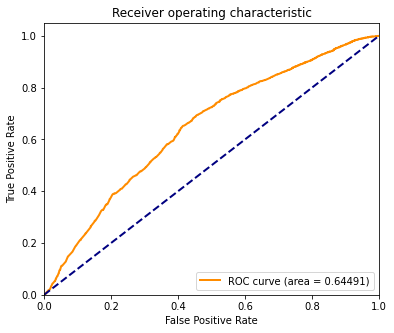

In [83]:
# x=pd.read_csv('./tmp/leave_one_process_out_k_10_m_1000_n_20.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_k_10_nb_100_bna_10_draw_objects_mk2.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_k_40_bireducts_1000_sample_attrs_100_max_attrs_10.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_same_category_bireducts_1_sample_attrs_100_max_attrs_100.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_same_category_bireducts_1000_sample_attrs_100_max_attrs_20.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_same_category_bireducts_1000_sample_attrs_200_max_attrs_30.csv', sep=';')
# x=pd.read_csv('./tmp/leave_one_process_out_k_40_bireducts_1000_candidate_attrs_50_max_attrs_30_eps_0.2_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_100_candidate_attrs_20_allowed_randomness_0.1_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_None_bireducts_100_candidate_attrs_20_allowed_randomness_0.1_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_100_candidate_attrs_20_allowed_randomness_0.1_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_500_candidate_attrs_30_allowed_randomness_0.1_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_500_candidate_attrs_30_allowed_randomness_0.1_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_None_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.25_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_None_bireducts_1000_candidate_attrs_100_allowed_randomness_0.25_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_1000_candidate_attrs_100_allowed_randomness_0.25_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_draw_uni_dec_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_draw_uni_dec_leave_one_process_out_k_None_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_draw_uni_dec_leave_one_process_out_same_category_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_None_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')

# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_2000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_None_bireducts_2000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_same_category_bireducts_2000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')


# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_500_candidate_attrs_100_allowed_randomness_0.1_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_500_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')

####
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.25_annonymized_discretized_kmeans.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_1000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_2000_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_500_candidate_attrs_100_allowed_randomness_0.1_annonymized_discretized_quantile.csv', sep=';')
# x=pd.read_csv('./tmp/daab_leave_one_process_out_k_40_bireducts_500_candidate_attrs_100_allowed_randomness_0.05_annonymized_discretized_quantile.csv', sep=';')


# fpr, tpr, _ = roc_curve(df_dec, np.nan_to_num(x[0]/x[1]))
fpr, tpr, _ = roc_curve(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 1]), pos_label=1)

plt.figure(figsize=(6, 5))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.5f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [7]:
import re
from collections import defaultdict

import seaborn as sns

In [10]:
result = []
# for p in (TMP_DIR/'paper_xgboost_1000').glob('*.csv'):
for p in (TMP_DIR / "paper").glob("*.csv"):
    # for p in (TMP_DIR/'paper_max_3_attrs').glob('*.csv'):
    m = re.search(r"k_(\d+)", p.name)
    if m is not None:
        k = int(m.group(1))
        x = pd.read_csv(p, sep=";")
        result.append(
            [k, roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 1]))]
        )
result = pd.DataFrame(result, columns=("k", "AUC"))

In [12]:
result.sort_values("AUC")

,k,AUC
27,10,0.611325
20,10,0.611954
88,10,0.617295
64,10,0.618558
80,10,0.619185
...,...,...
3,120,0.663669
52,50,0.664274
76,180,0.664755
62,50,0.664886


<AxesSubplot:xlabel='k', ylabel='AUC'>

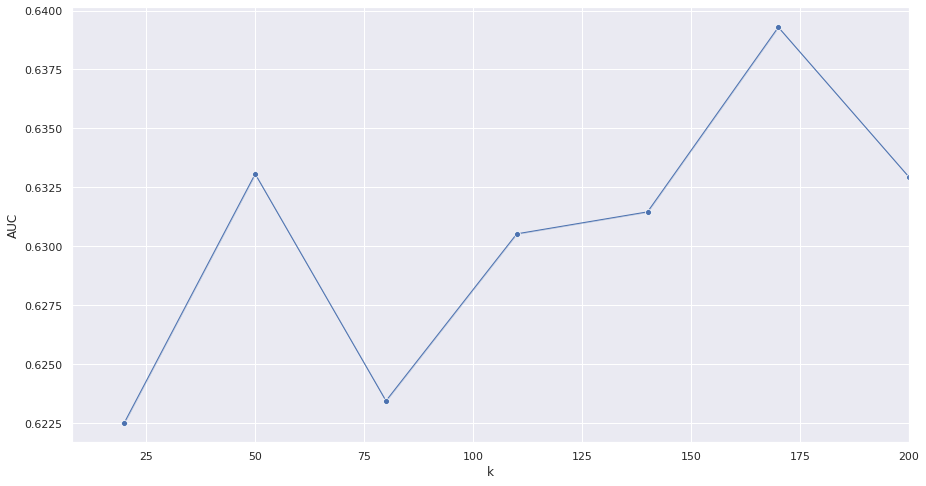

In [41]:
sns.set_theme()
plt.figure(figsize=(15, 8))
plt.xlim(8, 200)
sns.lineplot(data=result, x="k", y="AUC", markers=True, marker="o", lw=1)

<AxesSubplot:xlabel='k', ylabel='AUC'>

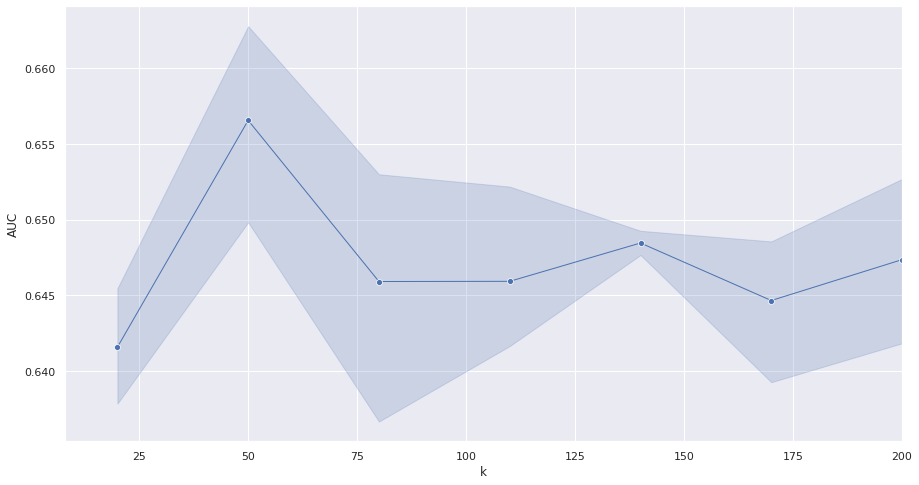

In [39]:
sns.set_theme()
plt.figure(figsize=(15, 8))
plt.xlim(8, 200)
sns.lineplot(data=result, x="k", y="AUC", markers=True, marker="o", lw=1)